# EEG thinking and reading - comparing effect of sample sizes

Breaking samples into 0.05, 0.1s, 0.2s, 0.3s, 0.4s, 0.5s
(Not an entirely fair comparison - different no. of features, different no. of samples)

1. Filtering 
2. Obtain datasets (Only using theta and alpha band frequency information)
3. Feature Extraction - Welch's method to extract PSD
4. PSD - 99% retained
5. Cross validation 
6. Compare F1 Scores

In [1]:
#Import necessary libraries

import pandas as pd
import numpy as np
from scipy import signal
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle as pkl
import itertools 
import glob
from sklearn import svm 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA

# %matplotlib inline 
%matplotlib qt


## Preprocessing

In [2]:
#Importing raw data files 

#.csv path
csvpath = "C:/Users/Wu Di/Documents/EEG-analysis/200108-Readings-csv/reading_switching.csv"

#Read .csv files
cols_to_use = list(range(4, 36))

#Raw dataframes - each channel is a column
raw_df = pd.read_csv(csvpath, header=None, usecols=cols_to_use)


In [3]:
#Bandpass (BP) filter helper functions

#Creates butterworth BP filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5*fs  # Nyquist frequency, which is half of fs
    low = lowcut/nyq  # Digital butterworth filter cutoffs must be normalized to Nyquist frequency
    high = highcut/nyq
    b, a = signal.butter(order, [low, high], btype="bandpass")
    return b, a

def butter_lowpass(cutFreq,fs,order=5):
    nyq = 0.5*fs
    cutFreq = cutFreq/nyq
    b,a = signal.butter(order,cutFreq,btype="lowpass")
    return b,a 

def butter_highpass(cutFreq,fs,order=5):
    nyq = 0.5*fs
    cutFreq = cutFreq/nyq
    b,a = signal.butter(order,cutFreq,btype="highpass")
    return b,a 

#Applies butterworth BP filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     filtered_data = signal.lfilter(b, a, data)
    filtered_data = signal.filtfilt(b,a,data)
    return filtered_data

#Applies butterworth lowpass filter
def butter_lowpass_filter(data, cutFreq, fs, order=5):
    b, a = butter_lowpass(cutFreq,fs,order=5)
    filtered_data = signal.filtfilt(b,a,data)
    return filtered_data

#Applies butterworth lowpass filter
def butter_highpass_filter(data, cutFreq, fs, order=5):
    b, a = butter_highpass(cutFreq,fs,order=5)
    filtered_data = signal.filtfilt(b,a,data)
    return filtered_data

#Applies butterworth BP filter to Pandas dataframe 
def bp_filter_df(df, lowcut, highcut, fs, order):
    rows, cols = df.shape  # Get no. of rows and cols in df
    new_index = range(1, rows+1)
    new_cols = range(1, cols+1)
    # Create new df with same no. of rows and cols
    new_df = pd.DataFrame(index=new_index, columns=new_cols)
    # new_df = new_df.fillna(0) #Fill in 0 for all values
    for i in range(cols):  # Apply bp filter each column (channel) and saves in new_df
        filt_col = butter_bandpass_filter(
            df.iloc[:, i].values, lowcut, highcut, fs, order)
        new_df[i+1] = filt_col
    return new_df

#Applies butterworth lowpass filter to Pandas dataframe 
def lp_filter_df(df, cutFreq, fs, order):
    rows, cols = df.shape  # Get no. of rows and cols in df
    new_index = range(1, rows+1)
    new_cols = range(1, cols+1)
    # Create new df with same no. of rows and cols
    new_df = pd.DataFrame(index=new_index, columns=new_cols)
    # new_df = new_df.fillna(0) #Fill in 0 for all values
    for i in range(cols):  # Apply bp filter each column (channel) and saves in new_df
        filt_col = butter_lowpass_filter(
            df.iloc[:, i].values, cutFreq, fs, order)
        new_df[i+1] = filt_col
    return new_df

#Applies butterworth highpass filter to Pandas dataframe 
def hp_filter_df(df, cutFreq, fs, order):
    rows, cols = df.shape  # Get no. of rows and cols in df
    new_index = range(1, rows+1)
    new_cols = range(1, cols+1)
    # Create new df with same no. of rows and cols
    new_df = pd.DataFrame(index=new_index, columns=new_cols)
    # new_df = new_df.fillna(0) #Fill in 0 for all values
    for i in range(cols):  # Apply bp filter each column (channel) and saves in new_df
        filt_col = butter_highpass_filter(
            df.iloc[:, i].values, cutFreq, fs, order)
        new_df[i+1] = filt_col
    return new_df

In [7]:
#Apply BP filtering to raw dataframes
def filt_freq_bands(df,fs):
    delta = lp_filter_df(df, 4.5, fs, 10) 
    theta = bp_filter_df(df, 3.5, 8.5, fs, 6)
    alpha = bp_filter_df(df, 7.5, 12.5, fs, 8)
    beta = bp_filter_df(df, 11.5, 30.5, fs, 16)
    gamma = hp_filter_df(df, 29.5, fs, 50)
    return [delta, theta, alpha, beta, gamma]

fs = 128
# order = 6

all_bands_list = filt_freq_bands(raw_df,fs)

#Split into thinking and counting data frames
think_index_list = []
count_index_list = []

for i in range(6):
    if i%2==0:
        think_index_list+=(list(range(1280*i,1280*(i+1))))
    else:
        count_index_list+=(list(range(1280*i,1280*(i+1))))

think_bands_list = []
read_bands_list = []

for i in range(len(all_bands_list)):
    df = all_bands_list[i].iloc[0:1280*6]
    df_list = np.vsplit(df,6)
    think_df = pd.DataFrame(np.vstack((df_list[0],df_list[2],df_list[4])))
    think_bands_list.append(think_df)
    read_df = pd.DataFrame(np.vstack((df_list[1],df_list[3],df_list[5])))
    read_bands_list.append(count_df)

print(think_bands_list[0].shape)
print(read_bands_list[0].shape)

(3840, 32)
(3840, 32)


In [8]:
#Keep only the alpha and theta bands
#"TA" meaning theta and alpha
think_TA_list = think_bands_list[1:3]
read_TA_list = read_bands_list[1:3]

print(len(think_TA_list))
print(len(count_TA_list))

2
2


In [6]:
#Splits a single dataframe into list of equally sized arrays
#Each element in list is nx32 array, where n= sample length 
def split_df(df,fs,sample_t,check=False):
    rows,_ = df.shape #get no. of rows
    sample_len = int(sample_t*fs) #find no. of recorded samples required for each sample time length
    Ns = int(rows/sample_len) #find total no. of samples
    df_cut = df.iloc[:Ns*sample_len] #truncate dataframe to exact multiple of sample length
    # print(Ns*sample_len)
    # print(Ns)
    df_split_list = np.vsplit(df_cut,Ns) #split dataframe row-wise, returns a list
    
    if check:
        print("Total no. of recorded samples: "+str(rows))
        print("Sample length: "+str(sample_len))
        print("Total no. of samples: "+str(Ns))
        print("Length of df_split_list: "+str(len(df_split_list)))
        
        if all(isinstance(x.shape,tuple) for x in df_split_list):
            print("Shape of each element in df_split_list: "+str(df_split_list[0].shape))
        else:
            print("Shapes are wrong.")
            for x in df_split_list:
                print(x.shape)
    return df_split_list,Ns

#Apply split_df() function to list of dataframes, reshape dataframe such that each element is an array 
#for the appropriate sample time length 
def split_bands_list(bands_list,fs,sample_t,check=False,checkSD=False):
    df_list_rFE = [0]*len(bands_list) #dataframes list ready for feature extraction 
    for df_no in range(len(bands_list)):
        df_split_list,Ns = split_df(bands_list[df_no],fs,sample_t,check=checkSD)
        list_of_series = [0]*Ns
        for i in range(len(df_split_list)):
            #New dataframe will have shape Nsx32, each element is a 1xsample_len array 
            new_row = [0]*32 
            #Each df_split_list[i] is a dataframe
            for j in range(len(df_split_list[i].columns)):
                new_row[j] = df_split_list[i].iloc[:,j].values 
            list_of_series[i] = new_row
        df_list_rFE[df_no] = pd.DataFrame(list_of_series)
    if check:
        print("Length of bands_list: "+str(len(bands_list)))
        print("Length of df_list_rFE: "+str(len(df_list_rFE)))
        if (all(isinstance(x.shape,tuple) for x in df_list_rFE)) and (Ns==len(df_list_rFE[0].index)):
            print("Shape of each dataframe in df_list_rFE: "+str(df_list_rFE[0].shape))
    return df_list_rFE
            



In [9]:
#Split filtered dataframes into samples
fs = 128 #sampling freq
sample_t_list = [0.025,0.05,0.1,0.2,0.3,0.4,0.5] #sample time lengths in seconds

#Function to apply split_bands_list function once for each sample time
def apply_multipleSplits(bands_list,fs,sample_t_list,checks=[True,False]):
    #Output is a list of bands_split lists
    bands_splits_lists = [0]*len(sample_t_list)
    for i in range(len(sample_t_list)):
        bands_splits_lists[i] = split_bands_list(bands_list,fs,sample_t_list[i],check=checks[0],checkSD=checks[1])
    return bands_splits_lists


In [10]:
T_TA_splits_list = apply_multipleSplits(think_TA_list,fs,sample_t_list)

Length of bands_list: 2
Length of df_list_rFE: 2
Shape of each dataframe in df_list_rFE: (1280, 32)
Length of bands_list: 2
Length of df_list_rFE: 2
Shape of each dataframe in df_list_rFE: (640, 32)
Length of bands_list: 2
Length of df_list_rFE: 2
Shape of each dataframe in df_list_rFE: (320, 32)
Length of bands_list: 2
Length of df_list_rFE: 2
Shape of each dataframe in df_list_rFE: (153, 32)
Length of bands_list: 2
Length of df_list_rFE: 2
Shape of each dataframe in df_list_rFE: (101, 32)
Length of bands_list: 2
Length of df_list_rFE: 2
Shape of each dataframe in df_list_rFE: (75, 32)
Length of bands_list: 2
Length of df_list_rFE: 2
Shape of each dataframe in df_list_rFE: (60, 32)


In [12]:
R_TA_splits_list = apply_multipleSplits(read_TA_list,fs,sample_t_list)

Length of bands_list: 2
Length of df_list_rFE: 2
Shape of each dataframe in df_list_rFE: (1280, 32)
Length of bands_list: 2
Length of df_list_rFE: 2
Shape of each dataframe in df_list_rFE: (640, 32)
Length of bands_list: 2
Length of df_list_rFE: 2
Shape of each dataframe in df_list_rFE: (320, 32)
Length of bands_list: 2
Length of df_list_rFE: 2
Shape of each dataframe in df_list_rFE: (153, 32)
Length of bands_list: 2
Length of df_list_rFE: 2
Shape of each dataframe in df_list_rFE: (101, 32)
Length of bands_list: 2
Length of df_list_rFE: 2
Shape of each dataframe in df_list_rFE: (75, 32)
Length of bands_list: 2
Length of df_list_rFE: 2
Shape of each dataframe in df_list_rFE: (60, 32)


## Feature Extraction

In [14]:
#Apply Welch's method for each item in the dataframes

def welch_bands_split_list(bands_list,fs,win,check=False):
    #fs -sampling freq, win - number of recorded samples in window
    #Using this method, freq resolution = 1/t = fs/N (N=no.of points in windows)
    PSD_df_list = [0]*len(bands_list)
    for df_no in range(len(bands_list)):
        #Every item in the dataframe is mapped to the PSD estimates
        PSD_df_list[df_no] = bands_list[df_no].applymap(lambda x: signal.welch(x,fs,nperseg=win)[1])
    #Frequency axis for plotting, samee for all
    freqs,_ = signal.welch(bands_list[0].iloc[0,0],fs,nperseg=win)
    
    if check:
        if all(isinstance(x.shape,tuple) for x in PSD_df_list):
            print(PSD_df_list[0].shape)
#         if len(PSD_df_list[0].iloc[0,0]) == len(PSD_df_list[1].iloc[0,0]) == len(PSD_df_list[2].iloc[0,0]) == len(PSD_df_list[3].iloc[0,0]):
#             len(PSD_df_list[0].iloc[0,0]
    
    return freqs, PSD_df_list

fs = 128 
win_list = [1,3,6,12,19,25,32] #Windows are half of sample lengths (6,12,25,38,51,64)

#Apply welch_bands_split_list for the respective window lengths for splits_list
def apply_welch_splits(splits_list,fs,win_list,check=False):
    if len(splits_list) == len(win_list):
        freqs_diffSampLen_list = [0]*len(win_list)
        PSD_diffSampLen_df_list = [0]*len(win_list)
        for i in range(len(win_list)):
            freqs_diffSampLen_list[i],PSD_diffSampLen_df_list[i] = welch_bands_split_list(splits_list[i],fs,win_list[i],check=check)
    return freqs_diffSampLen_list,PSD_diffSampLen_df_list

# freqs_diffSampLen_list,PSD_diffSampLen_df_list = apply_welch_splits(T_TA_splits_list,fs,win_list)

#Get PSD estimates, freqs is the same for all
# freqs, T_PSD_df_list = welch_bands_split_list(T_bands_split_list,fs,win,check=True)
# _, C_PSD_df_list = welch_bands_split_list(C_bands_split_list,fs,win,check=True)

In [15]:
T_TA_freqs_list,T_TA_PSD_df_list = apply_welch_splits(T_TA_splits_list,fs,win_list)
R_TA_freqs_list,R_TA_PSD_df_list = apply_welch_splits(R_TA_splits_list,fs,win_list)

In [16]:
for i in range(len(T_TA_PSD_df_list)):
    for j in range(len(T_TA_PSD_df_list[i])):
        print(T_TA_PSD_df_list[i][j].shape)

for i in range(len(T_TA_freqs_list)):
    print(T_TA_freqs_list[i])

print("------------")

for i in range(len(R_TA_PSD_df_list)):
    for j in range(len(R_TA_PSD_df_list[i])):
        print(R_TA_PSD_df_list[i][j].shape)

for i in range(len(R_TA_freqs_list)):
    print(R_TA_freqs_list[i])

(1280, 32)
(1280, 32)
(640, 32)
(640, 32)
(320, 32)
(320, 32)
(153, 32)
(153, 32)
(101, 32)
(101, 32)
(75, 32)
(75, 32)
(60, 32)
(60, 32)
[0.]
[ 0.         42.66666667]
[ 0.         21.33333333 42.66666667 64.        ]
[ 0.         10.66666667 21.33333333 32.         42.66666667 53.33333333
 64.        ]
[ 0.          6.73684211 13.47368421 20.21052632 26.94736842 33.68421053
 40.42105263 47.15789474 53.89473684 60.63157895]
[ 0.    5.12 10.24 15.36 20.48 25.6  30.72 35.84 40.96 46.08 51.2  56.32
 61.44]
[ 0.  4.  8. 12. 16. 20. 24. 28. 32. 36. 40. 44. 48. 52. 56. 60. 64.]
------------
(1280, 32)
(1280, 32)
(640, 32)
(640, 32)
(320, 32)
(320, 32)
(153, 32)
(153, 32)
(101, 32)
(101, 32)
(75, 32)
(75, 32)
(60, 32)
(60, 32)
[0.]
[ 0.         42.66666667]
[ 0.         21.33333333 42.66666667 64.        ]
[ 0.         10.66666667 21.33333333 32.         42.66666667 53.33333333
 64.        ]
[ 0.          6.73684211 13.47368421 20.21052632 26.94736842 33.68421053
 40.42105263 47.15789474 53.

In [17]:
#Create features from PSD

#Gets AUC for a single sample length
def get_AUC_PSD_df_list(PSD_df_list):
    AUC_PSD_df_list = [0]*len(PSD_df_list)
    for df_no in range(len(PSD_df_list)):
        AUC_PSD_df_list[df_no] = PSD_df_list[df_no].applymap(lambda x: np.trapz(x))
    return AUC_PSD_df_list
#Applies getting AUC for multiple sample lengths 
def mul_get_AUC(sampLen_PSD_df_list):
    sampLen_AUC_PSD_df_list = [0]*len(sampLen_PSD_df_list)
    for i in range(len(sampLen_PSD_df_list)):
        sampLen_AUC_PSD_df_list[i] = get_AUC_PSD_df_list(sampLen_PSD_df_list[i])
    return sampLen_AUC_PSD_df_list

T_TA_AUC_df_list = mul_get_AUC(T_TA_PSD_df_list)
R_TA_AUC_df_list = mul_get_AUC(R_TA_PSD_df_list)

In [19]:
#Expand all lists in cells to their own variables

#Expands for a single PSD_df_list
def expand_PSD_df_list(PSD_df_list):
    e_PSD_df_list = [0]*len(PSD_df_list)
    for df_no in range(len(PSD_df_list)):
        #e_PSD_df_cols_list will be used to create new dataframe
        no_PSD = len(PSD_df_list[0].iloc[0,0])
        e_PSD_df_cols_list = [0]*32
        
        for channel in range(len(PSD_df_list[df_no].columns)):
            #Expand each column into its own dataframe
            new_col = PSD_df_list[df_no][channel].apply(pd.Series)
            #Rename every variable in the new column
            new_col = new_col.rename(columns = lambda x: "Ch"+str(channel+1)+'_'+str(np.linspace(0,64,no_PSD)[x]))
            #Add new_col to cols_list
            e_PSD_df_cols_list[channel] = new_col
        
        #Create new dataframe
        e_PSD_df = pd.concat(e_PSD_df_cols_list, axis=1)
        
        #Add to list
        e_PSD_df_list[df_no] = e_PSD_df
    return e_PSD_df_list 

#Expands for a list of PSD_df_lists
def mul_expand_PSD_df_list(sampLen_PSD_df_list):
    sampLen_e_PSD_df_list = [0]*len(sampLen_PSD_df_list)
    for i in range(len(sampLen_PSD_df_list)):
        sampLen_e_PSD_df_list[i] = expand_PSD_df_list(sampLen_PSD_df_list[i])
    return sampLen_e_PSD_df_list


T_TA_e_PSD_df_list = mul_expand_PSD_df_list(T_TA_PSD_df_list)
R_TA_e_PSD_df_list = mul_expand_PSD_df_list(R_TA_PSD_df_list)

if len(T_TA_e_PSD_df_list) == len(R_TA_e_PSD_df_list):
    print(len(T_TA_e_PSD_df_list))
    for i in range(len(T_TA_e_PSD_df_list)):
        for j in range(len(T_TA_e_PSD_df_list[i])):
            print("T"+str(i)+str(j)+" shape:"+str(T_TA_e_PSD_df_list[i][j].shape))
            print("C"+str(i)+str(j)+" shape:"+str(R_TA_e_PSD_df_list[i][j].shape))


7
T00 shape:(1280, 32)
C00 shape:(1280, 32)
T01 shape:(1280, 32)
C01 shape:(1280, 32)
T10 shape:(640, 64)
C10 shape:(640, 64)
T11 shape:(640, 64)
C11 shape:(640, 64)
T20 shape:(320, 128)
C20 shape:(320, 128)
T21 shape:(320, 128)
C21 shape:(320, 128)
T30 shape:(153, 224)
C30 shape:(153, 224)
T31 shape:(153, 224)
C31 shape:(153, 224)
T40 shape:(101, 320)
C40 shape:(101, 320)
T41 shape:(101, 320)
C41 shape:(101, 320)
T50 shape:(75, 416)
C50 shape:(75, 416)
T51 shape:(75, 416)
C51 shape:(75, 416)
T60 shape:(60, 544)
C60 shape:(60, 544)
T61 shape:(60, 544)
C61 shape:(60, 544)


In [20]:
#Create datasets - both theta and alpha bands will be used

#3 types of datasets to be formed:
#Only PSD features
#Only AUC features 
#Both PSD and AUC features 

#Apply to a single expanded PSD_df_list
def get_1F_combos_df_list(e_PSD_df_list): 
    #single feature
    combos = [(0,1)]
    combos_df_list = [0]*len(combos)
    for i in range(len(combos)):
        concat_list = [e_PSD_df_list[x] for x in combos[i]]
        combos_df_list[i] = pd.concat(concat_list,axis=1)
    return combos_df_list

#Apply to a list of expanded PSD_df_lists
def mul_get_1F_combos_df_list(sampLen_e_PSD_df_list):
    sampLen_1F_combos_df_list = [0]*len(sampLen_e_PSD_df_list) 
    for i in range(len(sampLen_e_PSD_df_list)):
        sampLen_1F_combos_df_list[i] = get_1F_combos_df_list(sampLen_e_PSD_df_list[i])
    return sampLen_1F_combos_df_list

#Apply to one set of expanded PSD_df_list and AUC_df_list
def get_2F_combos_df_list(PSD_df_list,AUC_df_list):
    #Two features
    combos= [(0,1)]
    combos_df_list = [0]*len(combos)
    for i in range(len(combos)):
        psd_list = [PSD_df_list[x] for x in combos[i]]
        auc_list = [AUC_df_list[x] for x in combos[i]]
        concat_list = psd_list + auc_list 
        combos_df_list[i] = pd.concat(concat_list,axis=1)
    return combos_df_list

#Apply to multiple sets of expanded PSD_df_list and AUC_df_list
def mul_get_2F_combos_df_list(sampLen_PSD_df_list,sampLen_AUC_df_list):
    if len(sampLen_PSD_df_list) == len(sampLen_AUC_df_list):
        sampLen_2F_combos_df_list = [0]*len(sampLen_PSD_df_list)
        for i in range(len(sampLen_PSD_df_list)):
            sampLen_2F_combos_df_list[i] = get_2F_combos_df_list(sampLen_PSD_df_list[i],sampLen_AUC_df_list[i])
    return sampLen_2F_combos_df_list


#List of dataframes with only PSD features
T_PSD_combos_df_list = mul_get_1F_combos_df_list(T_TA_e_PSD_df_list)
R_PSD_combos_df_list = mul_get_1F_combos_df_list(R_TA_e_PSD_df_list)

#List of dataframes with only AUC features
T_AUC_combos_df_list = mul_get_1F_combos_df_list(T_TA_AUC_df_list)
R_AUC_combos_df_list = mul_get_1F_combos_df_list(R_TA_AUC_df_list)

#List of dataframes with both features
T_AP_combos_df_list = mul_get_2F_combos_df_list(T_TA_e_PSD_df_list,T_TA_AUC_df_list)
R_AP_combos_df_list = mul_get_2F_combos_df_list(R_TA_e_PSD_df_list,R_TA_AUC_df_list)



In [21]:
print(len(T_PSD_combos_df_list[0]))

1


In [22]:
def check_combos_shapes(combos_df_list):
    for i in range(len(combos_df_list)):
        for j in range(len(combos_df_list[i])):
            print(combos_df_list[i][j].shape)

check_combos_shapes(T_PSD_combos_df_list)
check_combos_shapes(R_PSD_combos_df_list)
print("------")
check_combos_shapes(T_AUC_combos_df_list)
check_combos_shapes(R_AUC_combos_df_list)
print("------")
check_combos_shapes(T_AP_combos_df_list)
check_combos_shapes(R_AP_combos_df_list)

(1280, 64)
(640, 128)
(320, 256)
(153, 448)
(101, 640)
(75, 832)
(60, 1088)
(1280, 64)
(640, 128)
(320, 256)
(153, 448)
(101, 640)
(75, 832)
(60, 1088)
------
(1280, 64)
(640, 64)
(320, 64)
(153, 64)
(101, 64)
(75, 64)
(60, 64)
(1280, 64)
(640, 64)
(320, 64)
(153, 64)
(101, 64)
(75, 64)
(60, 64)
------
(1280, 128)
(640, 192)
(320, 320)
(153, 512)
(101, 704)
(75, 896)
(60, 1152)
(1280, 128)
(640, 192)
(320, 320)
(153, 512)
(101, 704)
(75, 896)
(60, 1152)


In [23]:
#Feature scaling all dataframes 

#Applies feature scaling to one combos_df_list
def featureScaling_df(combos_df_list):
    sc = StandardScaler()
    scaled_combos_df_list = [0]*len(combos_df_list)
    for i in range(len(combos_df_list)):
        df = combos_df_list[i]
        cols = df.columns
        scaled_combos_df_list[i] = pd.DataFrame(sc.fit_transform(df),columns=cols)

    return scaled_combos_df_list

# Applies feature scaling to list of combo_df_lists
def mul_featureScaling_df(sampLen_combos_df_list):
    sampLen_scaled_combos_df_list = [0]*len(sampLen_combos_df_list)
    for i in range(len(sampLen_combos_df_list)):
        sampLen_scaled_combos_df_list[i] = featureScaling_df(sampLen_combos_df_list[i])
    return sampLen_scaled_combos_df_list

sc_T_PSD_combos_df_list = mul_featureScaling_df(T_PSD_combos_df_list)
sc_R_PSD_combos_df_list = mul_featureScaling_df(R_PSD_combos_df_list)

sc_T_AUC_combos_df_list = mul_featureScaling_df(T_AUC_combos_df_list)
sc_R_AUC_combos_df_list = mul_featureScaling_df(R_AUC_combos_df_list)

sc_T_AP_combos_df_list = mul_featureScaling_df(T_AP_combos_df_list)
sc_R_AP_combos_df_list = mul_featureScaling_df(R_AP_combos_df_list)


check_combos_shapes(sc_T_PSD_combos_df_list)
check_combos_shapes(sc_R_PSD_combos_df_list)
print("------")
check_combos_shapes(sc_T_AUC_combos_df_list)
check_combos_shapes(sc_R_AUC_combos_df_list)
print("------")
check_combos_shapes(sc_T_AP_combos_df_list)
check_combos_shapes(sc_R_AP_combos_df_list)

(1280, 64)
(640, 128)
(320, 256)
(153, 448)
(101, 640)
(75, 832)
(60, 1088)
(1280, 64)
(640, 128)
(320, 256)
(153, 448)
(101, 640)
(75, 832)
(60, 1088)
------
(1280, 64)
(640, 64)
(320, 64)
(153, 64)
(101, 64)
(75, 64)
(60, 64)
(1280, 64)
(640, 64)
(320, 64)
(153, 64)
(101, 64)
(75, 64)
(60, 64)
------
(1280, 128)
(640, 192)
(320, 320)
(153, 512)
(101, 704)
(75, 896)
(60, 1152)
(1280, 128)
(640, 192)
(320, 320)
(153, 512)
(101, 704)
(75, 896)
(60, 1152)


In [24]:
print(len(sc_T_PSD_combos_df_list[0]))
print(len(sc_R_PSD_combos_df_list[0]))
print(len(sc_T_AUC_combos_df_list[0]))
print(len(sc_R_AUC_combos_df_list[0]))
print(len(sc_T_AP_combos_df_list[0]))
print(len(sc_R_AP_combos_df_list[0]))

1
1
1
1
1
1


In [25]:
#Flatten out list of lists since each sublist only has 1 element
sc_T_PSD_combos_df_list_f = [item for sublist in sc_T_PSD_combos_df_list for item in sublist]
sc_R_PSD_combos_df_list_f = [item for sublist in sc_R_PSD_combos_df_list for item in sublist]

sc_T_AUC_combos_df_list_f = [item for sublist in sc_T_AUC_combos_df_list for item in sublist]
sc_R_AUC_combos_df_list_f = [item for sublist in sc_R_AUC_combos_df_list for item in sublist]

sc_T_AP_combos_df_list_f = [item for sublist in sc_T_AP_combos_df_list for item in sublist]
sc_R_AP_combos_df_list_f = [item for sublist in sc_R_AP_combos_df_list for item in sublist]

def check_shapes(combos_df_list_f):
    for i in range(len(combos_df_list_f)):
        print(combos_df_list_f[i].shape)

check_shapes(sc_T_PSD_combos_df_list_f)
check_shapes(sc_R_PSD_combos_df_list_f)
print("----")
check_shapes(sc_T_AUC_combos_df_list_f)
check_shapes(sc_R_AUC_combos_df_list_f)
print("----")
check_shapes(sc_T_AP_combos_df_list_f)
check_shapes(sc_R_AP_combos_df_list_f)

(1280, 64)
(640, 128)
(320, 256)
(153, 448)
(101, 640)
(75, 832)
(60, 1088)
(1280, 64)
(640, 128)
(320, 256)
(153, 448)
(101, 640)
(75, 832)
(60, 1088)
----
(1280, 64)
(640, 64)
(320, 64)
(153, 64)
(101, 64)
(75, 64)
(60, 64)
(1280, 64)
(640, 64)
(320, 64)
(153, 64)
(101, 64)
(75, 64)
(60, 64)
----
(1280, 128)
(640, 192)
(320, 320)
(153, 512)
(101, 704)
(75, 896)
(60, 1152)
(1280, 128)
(640, 192)
(320, 320)
(153, 512)
(101, 704)
(75, 896)
(60, 1152)


In [27]:
#Append action type columns to all dataframes 

#Add action column for a list of dataframes
def add_action_col(df_list,action_type):
    new_list = [0]*len(df_list)
    for i in range(len(df_list)):
        new_df = df_list[i][:]
        new_df['Action'] = pd.Series(action_type,index=df_list[i].index) #add new column
        new_list[i] = new_df
    return new_list

sc_T_PSD_combosA_df_list_f = add_action_col(sc_T_PSD_combos_df_list_f,'T')
sc_R_PSD_combosA_df_list_f = add_action_col(sc_R_PSD_combos_df_list_f,'R')

sc_T_AUC_combosA_df_list_f = add_action_col(sc_T_AUC_combos_df_list_f,'T')
sc_R_AUC_combosA_df_list_f = add_action_col(sc_R_AUC_combos_df_list_f,'R')

sc_T_AP_combosA_df_list_f = add_action_col(sc_T_AP_combos_df_list_f,'T')
sc_R_AP_combosA_df_list_f = add_action_col(sc_R_AP_combos_df_list_f,'R')

check_shapes(sc_T_PSD_combosA_df_list_f)
check_shapes(sc_R_PSD_combosA_df_list_f)
print("----")
check_shapes(sc_T_AUC_combosA_df_list_f)
check_shapes(sc_R_AUC_combosA_df_list_f)
print("----")
check_shapes(sc_T_AP_combosA_df_list_f)
check_shapes(sc_R_AP_combosA_df_list_f)


(1280, 65)
(640, 129)
(320, 257)
(153, 449)
(101, 641)
(75, 833)
(60, 1089)
(1280, 65)
(640, 129)
(320, 257)
(153, 449)
(101, 641)
(75, 833)
(60, 1089)
----
(1280, 65)
(640, 65)
(320, 65)
(153, 65)
(101, 65)
(75, 65)
(60, 65)
(1280, 65)
(640, 65)
(320, 65)
(153, 65)
(101, 65)
(75, 65)
(60, 65)
----
(1280, 129)
(640, 193)
(320, 321)
(153, 513)
(101, 705)
(75, 897)
(60, 1153)
(1280, 129)
(640, 193)
(320, 321)
(153, 513)
(101, 705)
(75, 897)
(60, 1153)


In [29]:
#Combine different class types to form full datasets
def concatSave_df_list(T_df_list,C_df_list,sampLenStrings,filename,savedir,save=False):
    if len(C_df_list) == len(T_df_list):
        for i in range(len(C_df_list)):
            new_df = pd.concat([T_df_list[i],C_df_list[i]],axis=0)
            if save:
                savepath = savedir+filename+'_'+ sampLenStrings[i]+'.pkl'
                #Save to external HDD as pkl files 
                new_df.to_pickle(savepath)
            if i == 0:
                csvpath = savedir+filename+'_'+ sampLenStrings[i]+'.csv'
                new_df.to_csv(csvpath)
    else:
        print("Lists are of unequal lengths.")

sampLenStrings = ["0.025","0.05s","0.1s","0.2s","0.3s","0.4s","0.5s"]
AUC_savedir = "F:\EEG-data\\think-read\sampleSize_comparison\\featureScaled\AUC/"
PSD_savedir = "F:\EEG-data\\think-read\sampleSize_comparison\\featureScaled\PSD/"
AP_savedir = "F:\EEG-data\\think-read\sampleSize_comparison\\featureScaled\AUC_PSD/"
AUC_filename = "AUC_df"
PSD_filename = "PSD_df"
AP_filename = "AP_df"

#PSD
concatSave_df_list(sc_T_PSD_combosA_df_list_f,sc_R_PSD_combosA_df_list_f,sampLenStrings,PSD_filename,PSD_savedir,save=True)
#AUC
concatSave_df_list(sc_T_AUC_combosA_df_list_f,sc_R_AUC_combosA_df_list_f,sampLenStrings,AUC_filename,AUC_savedir,save=True)
#AUC PSD
concatSave_df_list(sc_T_AP_combosA_df_list_f,sc_R_AP_combosA_df_list_f,sampLenStrings,AP_filename,AP_savedir,save=True)

## SVM, Cross Validation, Evaluation

In [30]:
# Directories to load feature scaled datasets
loaddir = 'F:\EEG-data\\think-read\sampleSize_comparison\\featureScaled/'
loadAUC_dir = loaddir+'AUC/'
loadPSD_dir = loaddir+'PSD/'
loadAUC_PSD_dir = loaddir+'AUC_PSD/'

# Directories to save results
savedir = "F:\EEG-data\\think-read\sampleSize_comparison\PCA_CV_results/"
saveAUC_dir = savedir+'AUC/'
savePSD_dir = savedir+'PSD/'
saveAUC_PSD_dir = savedir+'AUC_PSD/'

In [31]:
# Cross-validation for SVM 
## Applies PCA only training set to retain 99% variance
## 80% training set, 20% test set
## 5 fold cross validation
def apply_PCA_CV_SVM(loaddir,savedir):
    files = glob.glob(loaddir+'*.pkl')
    sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    testdir = savedir+'testResults/'
    bestF1 = {'F1 Score':0,'dataset':'','params':''}
    test_results = {'F1 Score':[],'dataset':[],'params':[]}
    #Create PCA instances
    pca99 = PCA(n_components=0.99, svd_solver='full')
    #Instantiate SVM gridsearch
    C_range = [1,3,10,30,100,300,1000]
    param_grid= [
                # {'C': C_range, 'kernel': ['linear']},
                {'C': C_range, 'gamma': [0.001, 0.0001, 'auto', 'scale'], 'kernel': ['rbf']},
                ]
    scoring = {'accuracy','f1_macro'}
    clf = svm.SVC()
    grid = GridSearchCV(clf,param_grid=param_grid,scoring=scoring,cv=5,refit='f1_macro')
    #Apply PCA and Gridsearch
    for file in files:
        #Create filenames for saving
        cv99_filename = file.split("\\")[-1].rstrip('.pkl') +'_PCA99_CV_results.pkl'
        df = pd.read_pickle(file)
        X = df.iloc[:,:-1].values
        y = df.iloc[:,-1].values
        #Split into training and test sets
        for train_index, test_index in sss.split(X,y):
            X_train, X_test = X[train_index],X[test_index]
            y_train, y_test = y[train_index],y[test_index]
        #Fit transform on training data
        x_99_train = pca99.fit_transform(X_train)
        #Fit transform on test data
        x_99_test = pca99.transform(X_test)
        #Gridsearch
        grid99 = grid.fit(x_99_train,y_train)
        #Get number of principal components
        _,cols99 = x_99_train.shape
        #Get results
        results_df99 = pd.DataFrame(grid99.cv_results_)
        #Append number of principal components
        results_df99['No. of PC'] = [cols99]*len(results_df99.index) 
        #Save results
        results_df99.to_pickle(savedir+cv99_filename)
        #Export as csv 
        results_df99.to_csv(savedir+cv99_filename+'.csv')
        #Fit SVM on best parameters 
        best_params99 = results_df99.loc[results_df99['rank_test_f1_macro'].idxmin()]['params']
        
        clf99 = svm.SVC(**best_params99)
        clf99.fit(x_99_train,y_train)
        y_99_pred = clf99.predict(x_99_test)

        y_pred_list = [y_99_pred]
        x_test_list = [x_99_test]
        clf_list = [clf99]
        best_params_list =[best_params99]

        #Generate and save classification report, macro-avg f1 score, confusion matrix
        
        target_names = ['C','T']
        names_list = ['99']
        for i in range(len(y_pred_list)):
            df_name = file.split("\\")[-1].rstrip('.pkl')+'_'+names_list[i]
            report_name = file.split("\\")[-1].rstrip('.pkl') + '_'+names_list[i]+'_PCA_CV_SVM_clf_report'
            cm_name = file.split("\\")[-1].rstrip('.pkl') + '_'+names_list[i]+'_PCA_CV_SVM_ConfusionMatrix'
            ##Classification report 
            report = classification_report(y_test, y_pred_list[i], target_names=target_names, output_dict=True)
            report_df = pd.DataFrame(report).transpose()
            report_df.to_pickle(testdir+report_name+'.pkl')
            ##Macro-avg f1 score 
            f1Score = report['macro avg']['f1-score']
            test_results['F1 Score'].append(f1Score)
            test_results['dataset'].append(df_name)
            test_results['params'].append(best_params_list[i])
            test_results_df = pd.DataFrame(test_results)
            if bestF1['F1 Score']<f1Score:
                bestF1['F1 Score'] = f1Score
                bestF1['dataset'] = df_name
                bestF1['params'] = str(best_params_list[i])
            ##Confusion matrix
            fig,ax = plt.subplots()
            ax.set_title(df_name+' CM')
            plot_confusion_matrix(clf_list[i],x_test_list[i],y_test,labels=target_names,ax=ax,normalize='true')
            plt.savefig(testdir+df_name+'.png')
            plt.close()

    bestF1_df = pd.DataFrame(bestF1,index=[0],columns=['F1 Score','dataset','params'])
    bestF1_df.to_csv(testdir+bestF1['dataset']+'.csv')
    test_results_df.to_csv(testdir+'test_results.csv')
    test_results_df.to_csv(testdir+'test_results.pkl')
        


apply_PCA_CV_SVM(loadAUC_dir,saveAUC_dir)
apply_PCA_CV_SVM(loadPSD_dir,savePSD_dir)
apply_PCA_CV_SVM(loadAUC_PSD_dir,saveAUC_PSD_dir)


In [1]:
import spectrum as spec
import numpy as np

256


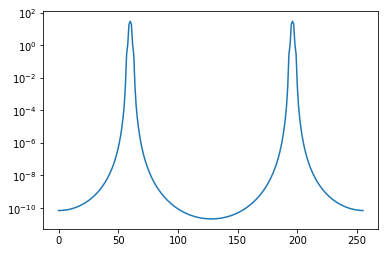

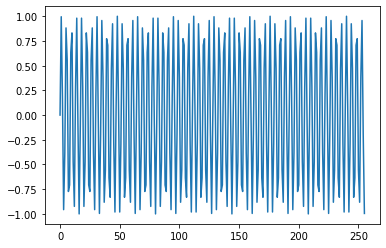

In [70]:
from spectrum import data_cosine, dpss, pmtm

# data = data_cosine(N=2048, A=0.1, sampling=1024, freq=200)
fs = 128
N = 2*fs
t = np.linspace(0,2-1/fs,N)
print(len(t))
data = np.sin(2*np.pi*30*t)
# If you already have the DPSS windows
# [tapers, eigen] = dpss(1000, 2.5, 4)
# res = pmtm(data, e=eigen, v=tapers, show=True)
# You do not need to compute the DPSS before end
# res = pmtm(data, NW=2.5, show=False)
res = pmtm(data, NW=2.5, show=True)
plt.figure(2)
plt.plot(data)

In [67]:
print(len(res[0]))
print(len(res[1]))
print(len(res[2]))

6
256
6


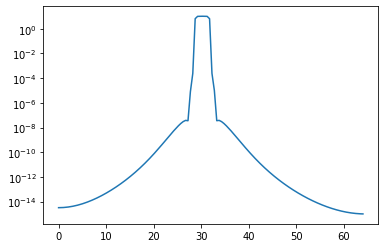

In [68]:
Sk_abs = abs(res[0])**2
weights = res[1]
Sk = np.mean(Sk_abs.transpose()*weights,axis=1)
import matplotlib.pyplot as plt
freq = np.linspace(0,fs/2,int(len(Sk)/2))
plt.semilogy(freq,Sk[:int(len(Sk)/2)])
# plt.plot(freq,Sk[:int(len(Sk)/2)])


# a = abs(res[0])**2
# import numpy as np
# import matplotlib.pyplot as plt 

# b = [0]*len(a[0])
# for i in range(len(a[0])):
#     for j in range(len(a)):
#         b[i] += a[j][i]
# print(len(b))

# plt.plot(b)
# plt.yscale('log')

In [8]:
#Import necessary libraries

import pandas as pd
import numpy as np
from scipy import signal
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle as pkl
import itertools 
import glob
from sklearn import svm 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA

%matplotlib inline 
# %matplotlib qt


In [9]:
# Directories to load feature scaled datasets
#Importing raw data files 

#.csv path
csvpath = "C:/Users/Wu Di/Documents/EEG-analysis/200108-Readings-csv/thinking-counting-switching.csv"

#Read .csv files
cols_to_use = list(range(4, 36))

#Raw dataframes - each channel is a column
raw_df = pd.read_csv(csvpath, header=None, usecols=cols_to_use)




In [22]:
data = raw_df.iloc[:,0].values
t = np.linspace(0,1000,1001)
data = np.sin(2*np.pi*20*t/1000)

In [20]:
len(data)

1001

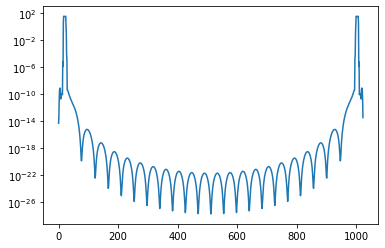

In [26]:
res = pmtm(data, NW=4, show=True)

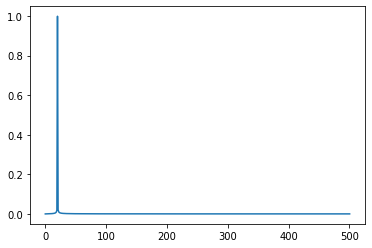

In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = len(data)
# sample spacing
T = 1/1001
x = np.linspace(0.0, N*T, N)
yf = scipy.fftpack.fft(data)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()